In [1]:
import scvi

/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
import scanpy as sc
import scipy

In [7]:
sample = 'B08'
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_membership = pd.concat((allen_membership,
                              allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)),
                              axis=1)

allen_membership = allen_membership[allen_membership['sample'] == sample]

In [8]:
allen_membership

,barcode,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
66697,AAACCCAAGTACGAGC-10L8TX_190430_01_B08,93,AAACCCAAGTACGAGC,B08,Vip Chat_low,Low Quality,Low Quality
66698,AAACCCAAGTGAACAT-10L8TX_190430_01_B08,42,AAACCCAAGTGAACAT,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
66699,AAACCCAAGTTGAATG-10L8TX_190430_01_B08,40,AAACCCAAGTTGAATG,B08,L2/3 IT,L2/3 IT,Glutamatergic
66700,AAACCCACACCCTAGG-10L8TX_190430_01_B08,100,AAACCCACACCCTAGG,B08,Sst Myh8_3_low,Low Quality,Low Quality
66701,AAACCCACACGATAGG-10L8TX_190430_01_B08,42,AAACCCACACGATAGG,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
...,...,...,...,...,...,...,...
75116,TTTGTTGAGGGTTAAT-10L8TX_190430_01_B08,140,TTTGTTGAGGGTTAAT,B08,L6 NP Trh_low,Low Quality,Low Quality
75117,TTTGTTGCAAAGGATT-10L8TX_190430_01_B08,24,TTTGTTGCAAAGGATT,B08,Sst Myh8_1,Sst,GABAergic
75118,TTTGTTGGTGAGGAAA-10L8TX_190430_01_B08,28,TTTGTTGGTGAGGAAA,B08,Sst Hpse_3,Sst,GABAergic
75119,TTTGTTGTCCAAACCA-10L8TX_190430_01_B08,40,TTTGTTGTCCAAACCA,B08,L2/3 IT,L2/3 IT,Glutamatergic


In [10]:
raw_file = '/home/ggorin/count_data/loom_allen_kb/allen_'+sample+'_raw.loom'
ad = sc.read_loom(raw_file)

/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
ad = ad[ad.obs['barcode'].isin(allen_membership['cell_barcode'])]


In [17]:
ad.layers.pop('matrix')

/home/ggorin/miniconda3/envs/scvi/lib/python3.9/_collections_abc.py:910: ImplicitModificationWarning: Removing element `.layers['matrix']` of view, initializing view as actual.
  del self[key]


<8424x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 40016708 stored elements in Compressed Sparse Row format>

In [21]:
ad.X = ad.layers['spliced'] + ad.layers['unspliced']

In [22]:
ad.obs['total_cell_size'] = ad.X.sum(1)
ad.obs['log_cell_size'] = np.log10(ad.obs['total_cell_size'])

In [27]:
obs_df = ad.obs
obs_df=obs_df.merge(allen_membership,left_on='barcode',right_on='cell_barcode').drop(['barcode_x','barcode_y'],axis=1)
ad.obs=obs_df

In [29]:
ad.write_h5ad('/home/ggorin/projects/monod_examples/manuscript_computation/scvi/gg_240702_allen_B08/ad_raw.h5ad')

In [51]:
ad.raw = ad  # keep full dimension safe
sc.pp.highly_variable_genes(
    ad,
    flavor="seurat_v3",
    n_top_genes=2000,
    subset=True,
)


/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [52]:
scvi.model.SCVI.setup_anndata(ad)

In [53]:
ad

AnnData object with n_obs × n_vars = 8424 × 2000
    obs: 'total_cell_size', 'log_cell_size', 'cluster_id', 'cell_barcode', 'sample', 'cluster_label', 'subclass_label', 'class_label', '_scvi_batch', '_scvi_labels'
    var: 'gene_id', 'gene_name', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_scVI'
    layers: 'spliced', 'unspliced'

In [54]:
model = scvi.model.SCVI(ad, n_layers=2, n_latent=10, gene_likelihood="nb")


In [57]:
model.train()


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=87` in the `DataLoader` to improve performance.


Epoch 400/400: 100%|██████████████████████████████| 400/400 [06:02<00:00,  1.11it/s, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.59e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████████████████████| 400/400 [06:02<00:00,  1.10it/s, v_num=1, train_loss_step=1.67e+3, train_loss_epoch=1.59e+3]


In [58]:
SCVI_LATENT_KEY = "X_scVI"
ad.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()


In [61]:
model.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

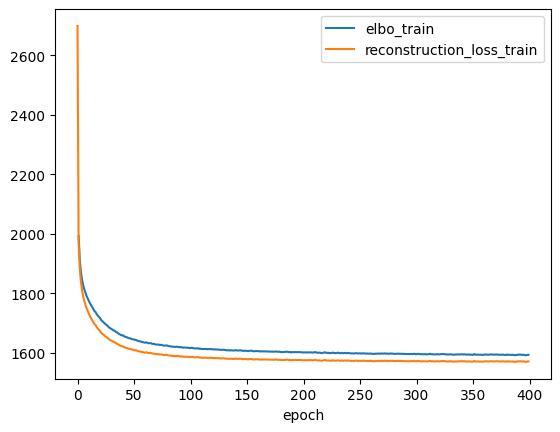

In [65]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["reconstruction_loss_train"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

In [68]:
sc.pp.neighbors(ad, use_rep=SCVI_LATENT_KEY)


In [70]:
sc.tl.leiden(ad)


/tmp/ipykernel_848219/2262893732.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(ad)


In [71]:
sc.tl.umap(ad)


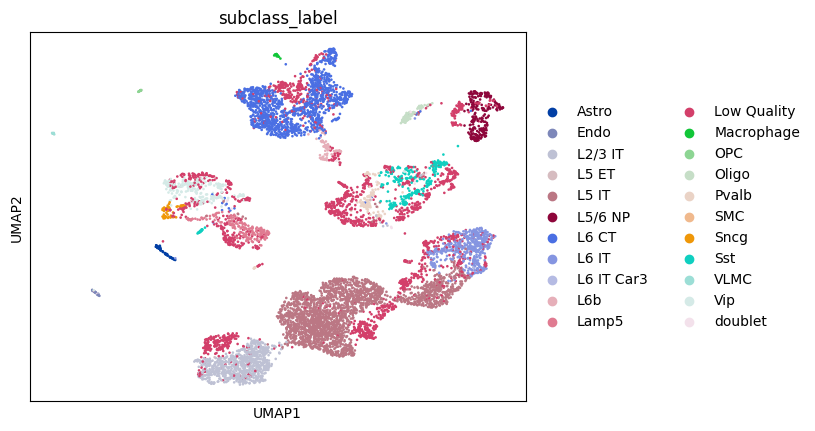

In [73]:
sc.pl.umap(ad,color=['subclass_label'])

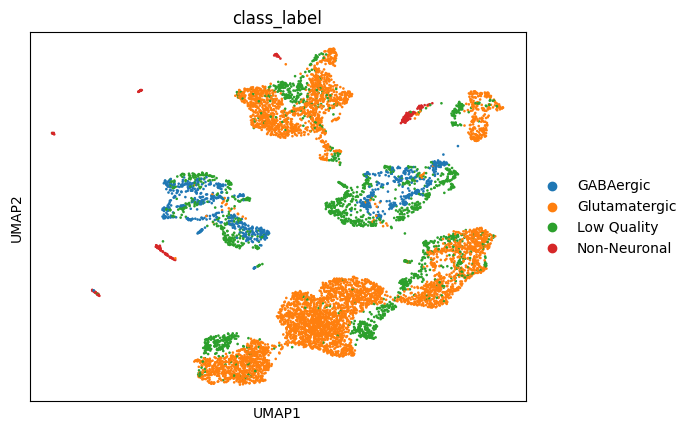

In [74]:
sc.pl.umap(ad,color=['class_label'])

In [75]:
model.save('/home/ggorin/projects/monod_examples/manuscript_computation/scvi/gg_240702_allen_B08/model', overwrite=True)


In [76]:
ad.write_h5ad('/home/ggorin/projects/monod_examples/manuscript_computation/scvi/gg_240702_allen_B08/ad_2k.h5ad')

In [77]:
ad_allgenes = sc.read_h5ad('/home/ggorin/projects/monod_examples/manuscript_computation/scvi/gg_240702_allen_B08/ad_raw.h5ad')

/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [81]:
ad_allgenes.obs=ad.obs
# ad_allgenes.var=ad.var
ad_allgenes.uns=ad.uns
ad_allgenes.obsm=ad.obsm
ad_allgenes.obsp=ad.obsp

In [84]:
ad = ad_allgenes

In [85]:
ad.write_h5ad('/home/ggorin/projects/monod_examples/manuscript_computation/scvi/gg_240702_allen_B08/ad_allgenes.h5ad')

In [97]:
ad.obs['unspliced_fraction'] = np.array(ad.layers['unspliced'].sum(1)).squeeze()/ad.obs['total_cell_size']

In [96]:
# np.array(ad.layers['unspliced'].sum(1)).squeeze()

array([ 6328., 30402., 20115., ..., 28130., 58439., 57389.], dtype=float32)

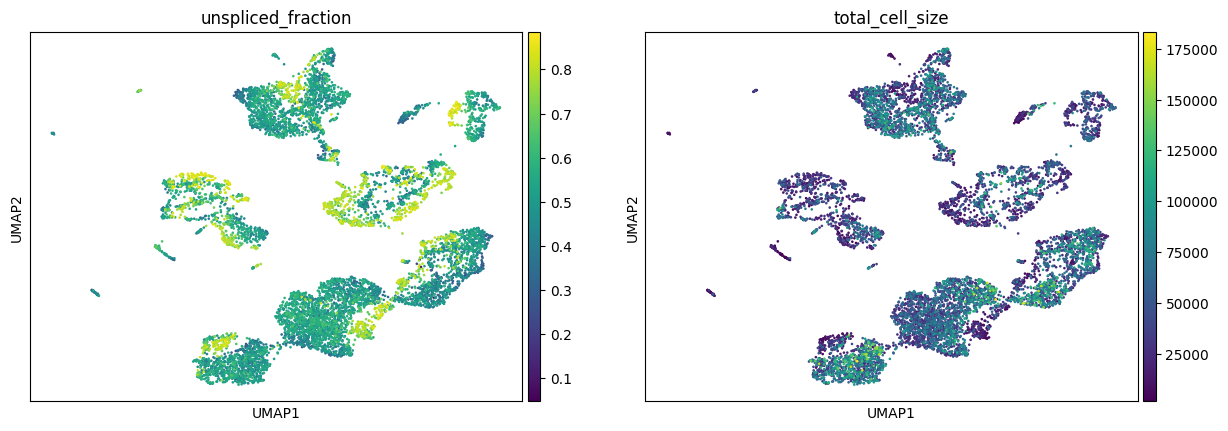

In [98]:
sc.pl.umap(ad,color=['unspliced_fraction','total_cell_size'])

In [102]:
ad.var.set_index('gene_name',inplace=True)

In [112]:
ad.layers['total']=ad.X

In [113]:
sc.pp.log1p(ad)


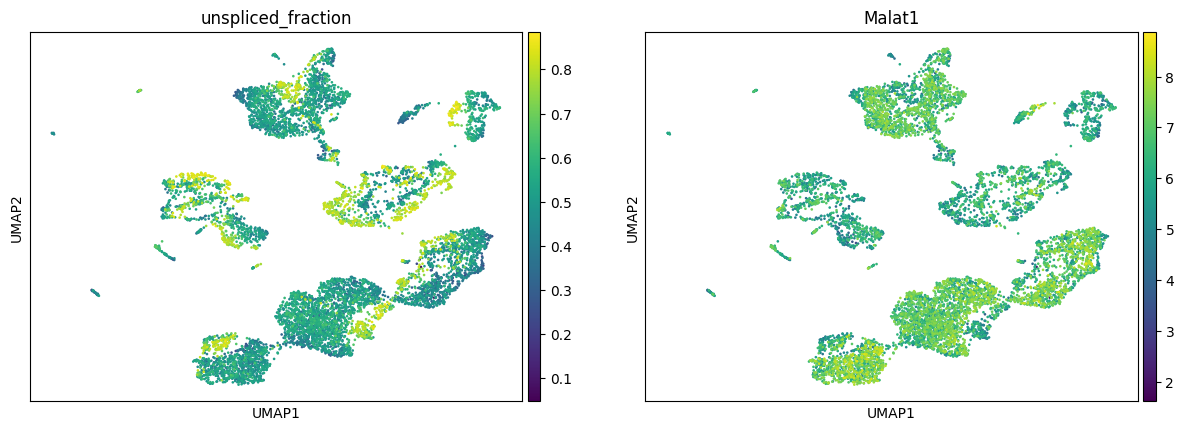

In [115]:
sc.pl.umap(ad,color=['unspliced_fraction','Malat1'])

# All Allen

In [13]:
libraries = ['H12','G12','A01','F01','B01','C01','D01','E01','F08','G08','A08','B08']

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
import scanpy as sc
import scipy
import tqdm

In [9]:
sample = 'B08'
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_membership = pd.concat((allen_membership,
                              allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)),
                              axis=1)
allen_membership['sample']=allen_membership['sample'].astype('category')


In [18]:
# allen_membership

In [15]:
set(allen_membership['sample'].cat.categories)==set(libraries)

True

In [39]:
ads=[]
for library in tqdm.tqdm(libraries):
    raw_file = '/home/ggorin/count_data/loom_allen_kb/allen_'+library+'_raw.loom'
    ad = sc.read_loom(raw_file)
    df = allen_membership[allen_membership['sample']==library]
    ad = ad[ad.obs['barcode'].isin(df['cell_barcode'])]
    obs_df = ad.obs

    obs_df=obs_df.merge(df,left_on='barcode',right_on='cell_barcode').drop(['barcode_x','barcode_y'],axis=1)
    ad.obs=obs_df
#     ads
#     break
    ads.append(ad)

  0%|                                                                                                                    | 0/12 [00:00<?, ?it/s]/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
  8%|█████████                                                                                                   | 1/12 [00:34<06:22, 34.76s/it]/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ggorin/miniconda3/envs/scvi/lib

In [31]:
obs_df

,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
0,40,AAACCCAAGACATAAC,H12,L2/3 IT,L2/3 IT,Glutamatergic
1,42,AAACCCAAGTTAACGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
2,40,AAACCCACAACACAAA,H12,L2/3 IT,L2/3 IT,Glutamatergic
3,41,AAACCCACAACTCATG,H12,L5 IT Tcap_1,L5 IT,Glutamatergic
4,60,AAACCCAGTCAAATCC,H12,L6 CT Cpa6_1,L6 CT,Glutamatergic
...,...,...,...,...,...,...
6860,42,TTTGTTGAGCCATCCG,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
6861,40,TTTGTTGAGCGAACTG,H12,L2/3 IT,L2/3 IT,Glutamatergic
6862,42,TTTGTTGAGCTGAGTG,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
6863,42,TTTGTTGCACTGAGGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic


In [32]:
allen_membership[allen_membership['sample']==library]

,barcode,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
6793,AAACCCAAGACATAAC-2L8TX_181211_01_H12,40,AAACCCAAGACATAAC,H12,L2/3 IT,L2/3 IT,Glutamatergic
6794,AAACCCAAGTTAACGA-2L8TX_181211_01_H12,42,AAACCCAAGTTAACGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
6795,AAACCCACAACACAAA-2L8TX_181211_01_H12,40,AAACCCACAACACAAA,H12,L2/3 IT,L2/3 IT,Glutamatergic
6796,AAACCCACAACTCATG-2L8TX_181211_01_H12,41,AAACCCACAACTCATG,H12,L5 IT Tcap_1,L5 IT,Glutamatergic
6797,AAACCCAGTCAAATCC-2L8TX_181211_01_H12,60,AAACCCAGTCAAATCC,H12,L6 CT Cpa6_1,L6 CT,Glutamatergic
...,...,...,...,...,...,...,...
13654,TTTGTTGAGCCATCCG-2L8TX_181211_01_H12,42,TTTGTTGAGCCATCCG,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
13655,TTTGTTGAGCGAACTG-2L8TX_181211_01_H12,40,TTTGTTGAGCGAACTG,H12,L2/3 IT,L2/3 IT,Glutamatergic
13656,TTTGTTGAGCTGAGTG-2L8TX_181211_01_H12,42,TTTGTTGAGCTGAGTG,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
13657,TTTGTTGCACTGAGGA-2L8TX_181211_01_H12,42,TTTGTTGCACTGAGGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic


In [40]:
ad = anndata.concat(ads)

/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ggorin/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [42]:
ad.obs

,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
0,40,AAACCCAAGACATAAC,H12,L2/3 IT,L2/3 IT,Glutamatergic
1,42,AAACCCAAGTTAACGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic
2,40,AAACCCACAACACAAA,H12,L2/3 IT,L2/3 IT,Glutamatergic
3,41,AAACCCACAACTCATG,H12,L5 IT Tcap_1,L5 IT,Glutamatergic
4,60,AAACCCAGTCAAATCC,H12,L6 CT Cpa6_1,L6 CT,Glutamatergic
...,...,...,...,...,...,...
8419,140,TTTGTTGAGGGTTAAT,B08,L6 NP Trh_low,Low Quality,Low Quality
8420,24,TTTGTTGCAAAGGATT,B08,Sst Myh8_1,Sst,GABAergic
8421,28,TTTGTTGGTGAGGAAA,B08,Sst Hpse_3,Sst,GABAergic
8422,40,TTTGTTGTCCAAACCA,B08,L2/3 IT,L2/3 IT,Glutamatergic


In [43]:
ad.write_h5ad('/home/ggorin/count_data/adata_allen_kb/ad.h5ad')

In [50]:
ad.layers.pop('matrix')

<94134x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 413270903 stored elements in Compressed Sparse Row format>

In [52]:
ad.X=ad.layers['spliced']+ad.layers['unspliced']

In [53]:
ad.obs['total_cell_size'] = ad.X.sum(1)
ad.obs['log_cell_size'] = np.log10(ad.obs['total_cell_size'])
ad.obs['unspliced_fraction'] = np.array(ad.layers['unspliced'].sum(1)).squeeze()/ad.obs['total_cell_size']

Text(0, 0.5, '# cells')

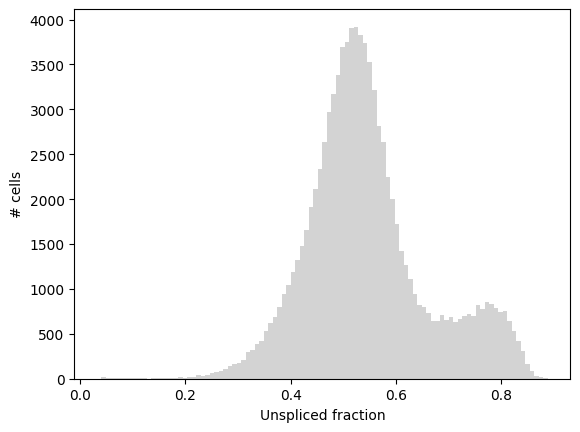

In [60]:
_=plt.hist(ad.obs['unspliced_fraction'],100,facecolor='lightgray')
plt.xlabel('Unspliced fraction')
plt.ylabel('# cells')

In [67]:
ads[0].var

,gene_id,gene_name
0,ENSMUSG00000079800.2,AC125149.3
1,ENSMUSG00000079192.2,AC125149.1
2,ENSMUSG00000094799.1,AC125149.4
3,ENSMUSG00000079794.2,AC125149.2
4,ENSMUSG00000095092.1,AC125149.5
...,...,...
32280,ENSMUSG00000103787.1,Gm37657
32281,ENSMUSG00000103752.5,Gm36467
32282,ENSMUSG00000103489.1,Gm37998
32283,ENSMUSG00000103524.1,Gm37263


In [68]:
ad.var=ads[0].var
ad.var.set_index('gene_name',inplace=True)

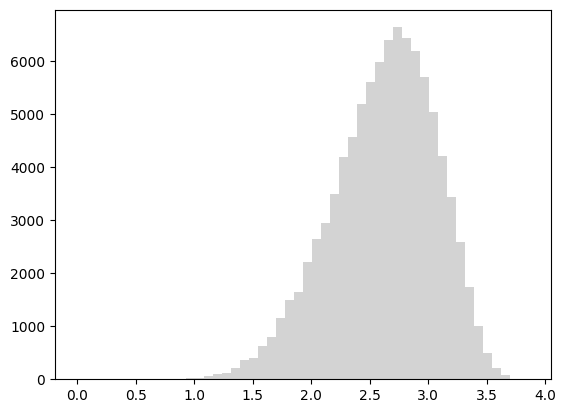

In [76]:
_=plt.hist(np.log10(1+ad[:,'Malat1'].X.toarray().squeeze()),50,facecolor='lightgray')

Text(0, 0.5, '# cells')

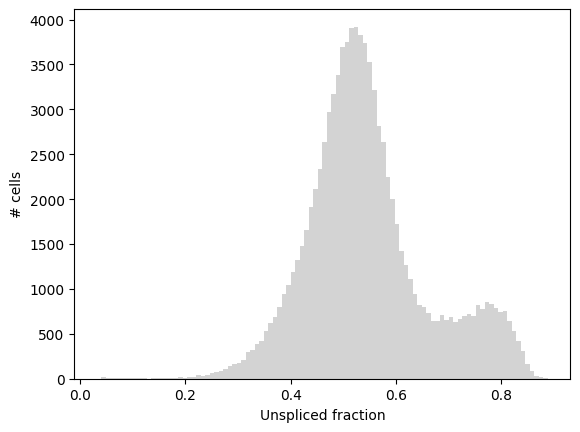

In [77]:
_=plt.hist(ad.obs['unspliced_fraction'],100,facecolor='lightgray')
plt.xlabel('Unspliced fraction')
plt.ylabel('# cells')

In [121]:
seaborn.reset_orig()


Text(0.5, 1.0, 'Low quality only')

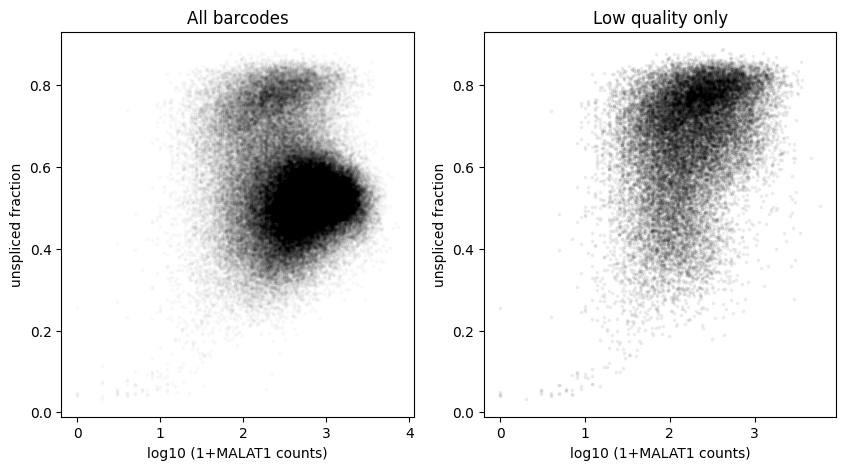

In [152]:
fig1,ax1=plt.subplots(1,2,figsize=(10,5))
ax1[0].scatter(np.log10(1+ad[:,'Malat1'].X.toarray().squeeze()),ad.obs['unspliced_fraction'],3,'k',alpha=0.02)
ax1[0].set_xlabel('log10 (1+MALAT1 counts)')
ax1[0].set_ylabel('unspliced fraction')

cf=ad.obs['class_label']=='Low Quality'
ax1[1].scatter(np.log10(1+ad[cf,'Malat1'].X.toarray().squeeze()),ad[cf].obs['unspliced_fraction'],3,'k',alpha=0.05)
ax1[1].set_xlabel('log10 (1+MALAT1 counts)')
ax1[1].set_ylabel('unspliced fraction')
ax1[0].set_title('All barcodes')
ax1[1].set_title('Low quality only')

In [151]:
len(ad)

94134

In [104]:
import seaborn as sns
color_labels = ad.obs['class_label'].cat.categories
rgb_values = sns.color_palette("Set2", 8)
color_map = dict(zip(color_labels, rgb_values))
# plt.scatter(df['carat'], df['price'], c=df['color'].map(color_map))


In [131]:
# sns.lmplot(x='carat', y='price', data=df, hue='color', fit_reg=False)


In [134]:
ad_.obs

,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label,total_cell_size,log_cell_size,unspliced_fraction
0,40,AAACCCAAGACATAAC,H12,L2/3 IT,L2/3 IT,Glutamatergic,33502.0,4.525071,0.418512
1,42,AAACCCAAGTTAACGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic,37169.0,4.570181,0.556324
2,40,AAACCCACAACACAAA,H12,L2/3 IT,L2/3 IT,Glutamatergic,75558.0,4.878281,0.465814
3,41,AAACCCACAACTCATG,H12,L5 IT Tcap_1,L5 IT,Glutamatergic,48533.0,4.686037,0.493829
4,60,AAACCCAGTCAAATCC,H12,L6 CT Cpa6_1,L6 CT,Glutamatergic,49153.0,4.691550,0.547027
...,...,...,...,...,...,...,...,...,...
1995,42,CATACTTAGGCATCGA,H12,L5 IT Tcap_2,L5 IT,Glutamatergic,32325.0,4.509539,0.602042
1996,43,CATACTTGTAGTGATA,H12,L5 IT S100b,L5 IT,Glutamatergic,41828.0,4.621467,0.468084
1997,42,CATACTTGTCCGAAAG,H12,L5 IT Tcap_2,L5 IT,Glutamatergic,34129.0,4.533123,0.464385
1998,61,CATACTTGTCGTCAGC,H12,L6 CT Cpa6_2,L6 CT,Glutamatergic,24129.0,4.382540,0.477144


In [144]:
# inds=np.arange(len(ad))
# for group in color_labels:
#     ad_ = ad[inds,'Malat1']
#     ad_ = ad_[ad_.obs['class_label']==group]
#     plt.scatter(np.log10(1+ad_.X.toarray().squeeze()),ad_.obs['unspliced_fraction'],3,
#                c=color_map[group],alpha=0.9,label=group)
# plt.legend()

In [108]:
color_map

{'GABAergic': (0.4, 0.7607843137254902, 0.6470588235294118),
 'Glutamatergic': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 'Low Quality': (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 'Non-Neuronal': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411)}

In [120]:
 ad[inds].obs['class_label'].map(color_map)

NotImplementedError: isna is not defined for MultiIndex